# Comparing `nnde` and TensorFlow for `lagaris01`: using optimizers

## Introduction

The purpose of this notebook is to provide a comparison between the `nnde` code and TensorFlow for the solution of the `lagaris01` ODE.

## The `lagaris01` problem

This ODE was used as the first example problem in (Lagaris et al., 1998). It has been used in several other papers in the neural network/differential equation literature. The differential equation is provided in the form (equation (27) in Lagaris (1998)):

\begin{equation}
    \frac {d\psi} {dx} + \left (x+\frac {1+3x^2} {1+x+x^3} \right ) \psi =
    x^3 + 2x + x^2 \frac {1+3x^2} {1+x+x^3}
\end{equation}

or:

\begin{equation}
    G\left(x,\psi,\frac {d\psi}{dx}\right) = \frac {d\psi} {dx} + \left (x+\frac {1+3x^2} {1+x+x^3} \right ) \psi - x^3 - 2x - x^2 \frac {1+3x^2} {1+x+x^3} = 0
\end{equation}

The initial condition is:

\begin{equation}
    \psi(0)=1
\end{equation}

The analytical solution is:

\begin{equation}
    \psi_a(x) = x^2 + \frac {e^{-x^2/2}} {1 + x +  x^3}
\end{equation}

The first derivative is:

\begin{equation}
    \frac {d\psi_a} {dx} = 2x - \frac {e^{-x^2/2} (1+x+4x^2+x^4)} {(1+x+x^3)^2}
\end{equation}

The analytical solution and derivative in the domain $[0,1]$ are plotted below.

In [1]:
# Import standard Python modules.
import datetime
from math import exp, sqrt
import matplotlib.pyplot as plt
import numpy as np

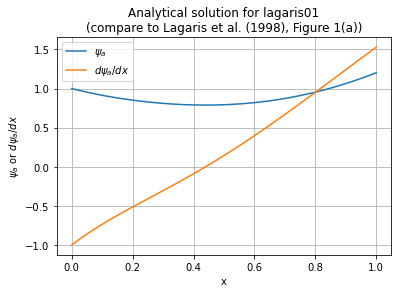

In [2]:
import nnde.differentialequation.examples.lagaris_01 as lagaris01

# Load the equation.
eq_name = "lagaris01"

# Compute the analytical solution and derivative.
na = 101
xa = np.linspace(0, 1, na)
Ya = np.zeros(na)
dYa_dx = np.zeros(na)
for i in range(na):
    Ya[i] = lagaris01.Ya(xa[i])
    dYa_dx[i] = lagaris01.dYa_dx(xa[i])

# Plot the analytical solution and derivative.
plt.plot(xa, Ya, label="$\psi_a$")
plt.plot(xa, dYa_dx, label="$d\psi_a/dx$")
plt.xlabel("x")
plt.ylabel("$\psi_a$ or $d\psi_a/dx$")
plt.grid()
plt.legend()
plt.title("Analytical solution for %s\n(compare to Lagaris et al. (1998), Figure 1(a))" %
         (eq_name));

## Shared hyperparameters

In [54]:
# Module and name for equation to solve
eq_module = "nnde.differentialequation.examples.lagaris_01"
eq_name = "lagaris01"

# Training data range
xmin = 0
xmax = 1

# Number of training points.
nt = 21

# Number of hidden nodes
num_hidden_nodes = 20

# Learning rate
learning_rate = 0.01

# Maximum number of training epochs
max_epochs = 1000

# Starting ranges for weights and biases.
b_min = -0.1
b_max = 0.1
v_min = -0.1
v_max = 0.1
w_min = -0.1
w_max = 0.1

## Solving `lagaris01` using the `nnde` package with BFGS optimizer

In [55]:
# Load the nnde packages needed for this problem.
from nnde.neuralnetwork.nnode1ivp import NNODE1IVP
from nnde.differentialequation.ode.ode1ivp import ODE1IVP

# Create the training data.
xt = np.linspace(xmin, xmax, nt)

# Create the ODE object for the problem.
ode = ODE1IVP(eq_module)

# Create the network.
net1 = NNODE1IVP(ode, nhid=num_hidden_nodes)

# Specify training options.
trainalg = "BFGS"
opts = {}
opts["eta"] = learning_rate
opts["maxepochs"] = max_epochs
opts["b_min"] = b_min
opts["b_max"] = b_max
opts["v_min"] = v_min
opts["v_max"] = v_max
opts["w_min"] = w_min
opts["w_max"] = w_max

# Train the network.
np.random.seed(0)
print(datetime.datetime.now())
%timeit -n 1 -r 1 net1.train(xt, trainalg=trainalg, opts=opts)
print(datetime.datetime.now())
print("Iterations used: %s" % net1.res.nit)

2021-05-29 10:49:15.940142
5.87 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2021-05-29 10:49:21.812150
Iterations used: 256


In [56]:
# Compute the trained model solution and derivative at the training points.
Ymt = net1.run(xt)
dYmt_dx = net1.run_derivative(xt)

# Compute the analytical solution and derivative at the training points.
Yat = [lagaris01.Ya(x) for x in xt]
dYat_dx = [lagaris01.dYa_dx(x) for x in xt]

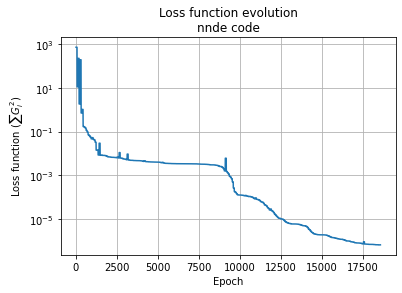

In [57]:
# Plot the loss function history.
plt.semilogy(net1.losses)
plt.xlabel("Epoch")
plt.ylabel("Loss function ($\sum G_i^2$)")
plt.grid()
plt.title("Loss function evolution\nnnde code")
plt.show()

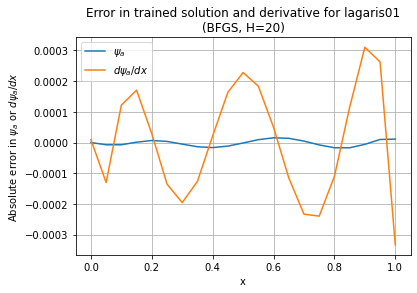

In [58]:
# Plot the errors in the analytical solution and derivative.
plt.plot(xt, Ymt - Yat, label="$\psi_a$")
plt.plot(xt, dYmt_dx - dYat_dx, label="$d\psi_a/dx$")
plt.xlabel("x")
plt.ylabel("Absolute error in $\psi_a$ or $d\psi_a/dx$")
plt.grid()
plt.legend()
plt.title("Error in trained solution and derivative for %s\n(%s, H=%s)" %
         ("lagaris01", trainalg, num_hidden_nodes))
plt.show()

## Solving `lagaris01` using TensorFlow

In [60]:
import tensorflow as tf

# Convert the training data to a TensorFlow Variable.
xtv = tf.Variable(xt.reshape((nt, 1)), dtype=tf.float32)

# Create the model.
tf.random.set_seed(0)
hidden_layer = tf.keras.layers.Dense(
    units=num_hidden_nodes, use_bias=True,
    activation=tf.keras.activations.sigmoid,
    kernel_initializer=tf.keras.initializers.RandomUniform(minval=w_min, maxval=w_max),
    bias_initializer=tf.keras.initializers.RandomUniform(minval=b_min, maxval=b_max)
)
output_layer = tf.keras.layers.Dense(
    units=1,
    activation=tf.keras.activations.linear,
    kernel_initializer=tf.keras.initializers.RandomUniform(minval=v_min, maxval=v_max)
)
model = tf.keras.Sequential([hidden_layer, output_layer])

# Create the optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

# Use the iteration count from the nnde run.
maxepochs = 1000

x = xtv
losses = []
print(datetime.datetime.now())
for i in range(maxepochs):
    # Compute the forward pass for each training point.
    with tf.GradientTape(persistent=True) as tape:
        N = model(x)
        N = tf.reshape(N, (nt, 1))
        y = 1 + x*N
        dN_dx = tape.gradient(N, x)
        G = x*dN_dx + N + (x + (1 + 3*x**2)/(1 + x + x**3))*y - x**3 - 2*x - x**2*(1 + 3*x**2)/(1 + x + x**3)
        L = tf.reduce_sum(G**2)
        losses.append(L)

    # Compute the gradients.
    grad = tape.gradient(L, model.trainable_variables)

    # Update the parameters for this pass.
    optimizer.apply_gradients(zip(grad, model.trainable_variables))

print(datetime.datetime.now())

2021-05-29 10:50:16.845176
2021-05-29 10:50:21.430958


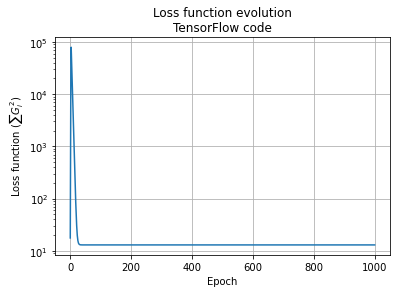

In [61]:
# Plot the loss function history.
plt.semilogy(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss function ($\sum G_i^2$)")
plt.grid()
plt.title("Loss function evolution\nTensorFlow code")
plt.show()

In [62]:
# Compute the trained solution.
with tf.GradientTape() as tape:
    N = model(xtv)
dN_dx = tape.gradient(N, xtv)
N = tf.reshape(N, (nt, 1))
dN_dx = tf.reshape(dN_dx, (nt, 1))
Ymt = 1 + xtv*N
dYmt_dx = xtv*dN_dx + N

# Compute the error in the trained solution and derivative.
err = Ymt.numpy().reshape((nt)) - Yat
derr = dYmt_dx.numpy().reshape((nt)) - dYat_dx

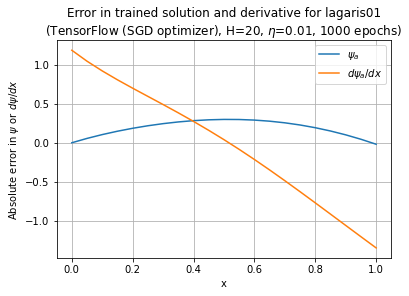

In [63]:
# Plot the errors in the trained solution and derivative.
plt.plot(xt, err, label="$\psi_a$")
plt.plot(xt, derr, label="$d\psi_a/dx$")
plt.xlabel("x")
plt.ylabel("Absolute error in $\psi$ or $d\psi/dx$")
plt.grid()
plt.legend()
plt.title("Error in trained solution and derivative for %s\n(%s, H=%s, $\eta$=%s, %s epochs)" %
         (eq_name, "TensorFlow (SGD optimizer)", num_hidden_nodes, learning_rate, maxepochs))
plt.show()